In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
def plot_results(imgs, labels=None):
    if labels is None:
        labels = [None for i in range(len(imgs))]
    plt.figure(figsize=(10, 10))
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis("off")

def normalise(img):
    img = np.float32(img)
    img -= np.min(img)
    img /= np.max(img)
    img = img*2 - 1
    return img

def norm_and_resize_with_padding(img, size):
    size_max = np.max(img.shape)
    r = size/size_max
    img = cv2.resize(img, (int(round(img.shape[1]*r)), int(round(img.shape[0]*r))))
    img = normalise(img)
    offset_height = (size - img.shape[0])//2
    offset_width = (size - img.shape[1])//2
    canvas = np.float32(-np.ones((size,size,3)))
    canvas[offset_height : offset_height + img.shape[0], offset_width : offset_width + img.shape[1]] = img
    return canvas

def import_images_from_folder(folder_path, size):
    imgs = []
    for relative_img_path in os.listdir(folder_path):
        if relative_img_path.endswith('.jpg'):
            img = cv2.imread(folder_path + relative_img_path)
            imgs.append(norm_and_resize_with_padding(img, size))
    print('Imported '+str(len(imgs))+' images.')
    return imgs

def to_uint8(img):
    return np.uint8((img + 1) * 127.5)

In [ ]:
# Dataset. In diesem Tutorial trainieren wir auf Oxford Flowers (107 categories).
# lässt sich hier herunterladen: https://www.robots.ox.ac.uk/~vgg/data/flowers/
# Ich habe anschließend das zip-Archiv entpackt und den resultierenden Ordner 'jpg' in 'flowers' umbenannt.

Imported 8189 images.


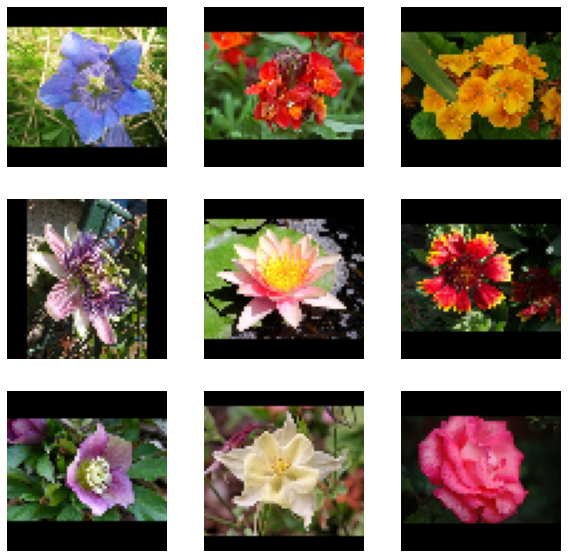

In [3]:
img_size = 64
images = import_images_from_folder('./flowers/', img_size)
plot_results([to_uint8(x) for x in images[:9]])

In [4]:
# images in richtige Form für torch bringen
images = np.float32(images)
images = np.transpose(images, (0, 3, 1, 2))
images = torch.Tensor(images)

In [21]:
class Generator(nn.Module):
    def __init__(
        self,
        n_latent_dimensions,
        channel_multiplier
        ):
        # inherit
        super(Generator, self).__init__()
        # write additional args
        self.n_latent_dimensions = n_latent_dimensions

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(
                in_channels = n_latent_dimensions,
                out_channels = channel_multiplier*8, 
                kernel_size = 4,
                bias=False),
            nn.BatchNorm2d(channel_multiplier*8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(channel_multiplier*8, channel_multiplier*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(channel_multiplier* 4, channel_multiplier* 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(channel_multiplier*2, channel_multiplier, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(channel_multiplier, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        x = torch.unsqueeze(torch.unsqueeze(input, -1), -1)
        return self.main(x)

In [22]:
class Discriminator(nn.Module):
    def __init__(
        self,
        channel_multiplier
        ):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, channel_multiplier, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(channel_multiplier, channel_multiplier*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(channel_multiplier*2, channel_multiplier*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(channel_multiplier*4, channel_multiplier*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(channel_multiplier*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(channel_multiplier*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Initialisierung
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Models definieren
n_latent_dimensions = 100
channel_multiplier=64

G = Generator(
    n_latent_dimensions=n_latent_dimensions,
    channel_multiplier=channel_multiplier
    )


D = Discriminator(
    channel_multiplier=channel_multiplier//4
    )


In [38]:
# Schnappen wir uns unsere GPU bzw. CPU wenn keine GPU vorhanden ist.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Nun kopieren wir unsere Models auf das device mit der Methode .to
D = D.to(device)
G = G.to(device)
G.apply(weights_init)
D.apply(weights_init)

# Den Optimizern in PyTorch übergeben wir die Methode 'parameters' des zu optimierenden Models und die learning rate.
opt_discriminator = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_generator = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [39]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, steps, n_latent_dimensions, images):
        'Initialization'
        self.images = images
        self.steps = steps
        self.n_latent_dimensions = n_latent_dimensions

    def __len__(self):
        'Denotes the total number of samples'
        return self.steps

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select image
        idx = np.random.choice(len(self.images))
        x = self.images[idx]
        # sample latent code
        z = np.float32(np.random.normal(0, 1, (self.n_latent_dimensions)))
        z = torch.Tensor(z)
        return x, z

In [45]:
def get_loader(steps, n_latent_dimensions, images):
    dataset = MyDataset(steps, n_latent_dimensions, images)
    train_loader = DataLoader(
        dataset,
        batch_size=512,
        shuffle=True,
        num_workers=24) # fairly strange... ist ein bug in pytorch bei single-gpu training.
    return train_loader

In [41]:
def plot_results(imgs, index):
    plt.figure(figsize=(10, 10))
    imgs = [x.cpu().detach().numpy() for x in imgs]
    imgs = [np.uint8(np.clip((img+1)*127.5, 0, 255)) for img in imgs]
    imgs = [np.transpose(x, (1,2,0)) for x in imgs]
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.axis("off")
    plt.savefig('output/'+str(index)+'.jpg')

d_loss: tensor(1.1381, device='cuda:0', grad_fn=<AddBackward0>) g_loss: tensor(2.7734, device='cuda:0', grad_fn=<MeanBackward0>): 100%|██████████| 1954/1954 [03:16<00:00,  9.97it/s]


epoch : 1/100, d_loss = 0.9960956573486328, g_loss = 1.456274


d_loss: tensor(0.5704, device='cuda:0', grad_fn=<AddBackward0>) g_loss: tensor(2.5954, device='cuda:0', grad_fn=<MeanBackward0>): 100%|██████████| 1954/1954 [03:14<00:00, 10.02it/s]


epoch : 2/100, d_loss = 0.7420134544372559, g_loss = 1.800927


d_loss: tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>) g_loss: tensor(3.3190, device='cuda:0', grad_fn=<MeanBackward0>): 100%|██████████| 1954/1954 [03:15<00:00, 10.00it/s]


epoch : 3/100, d_loss = 0.5822409391403198, g_loss = 2.305890


d_loss: tensor(0.7635, device='cuda:0', grad_fn=<AddBackward0>) g_loss: tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>):  69%|██████▉   | 1357/1954 [02:17<01:00,  9.86it/s]


KeyboardInterrupt: 

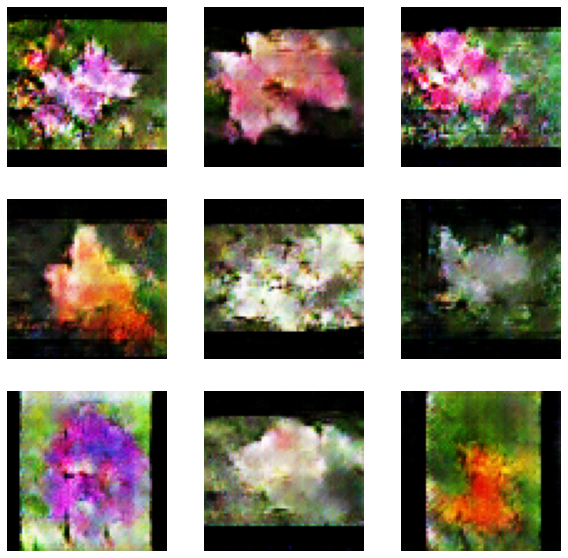

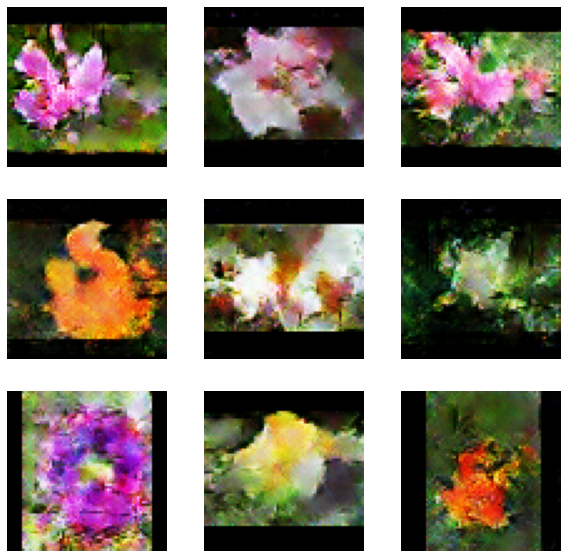

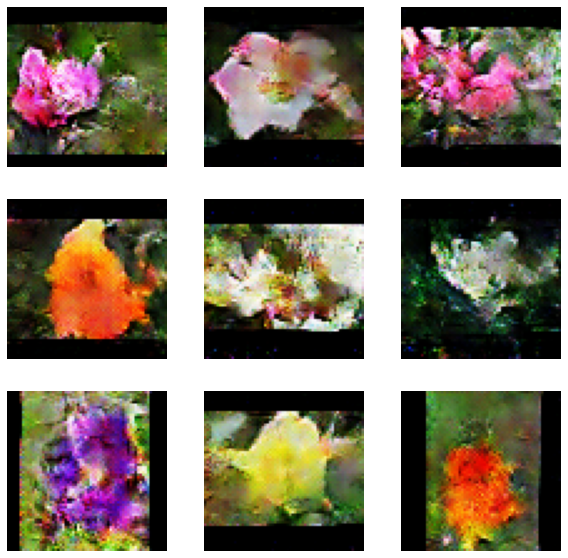

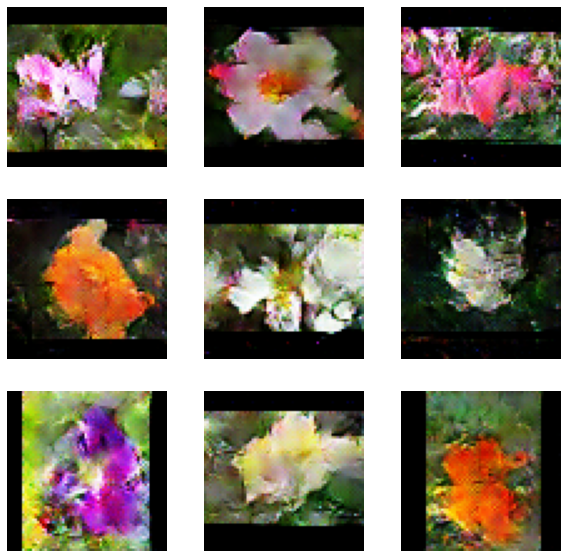

In [47]:
'''
Trainingsloop
'''

def train(n_epochs): 
    # init latent codes for testing
    z = np.float32(np.random.normal(0, 1, (9, n_latent_dimensions)))
    z = torch.tensor(z)
    z = z.to(device)
    
    # binary crossentropy
    def criterion(pred, true):
        loss = -(true * torch.log(pred+1e-7) + (1-true) * torch.log(1-pred+1e-7))
        loss = torch.mean(loss)
        return loss

    # Establish convention for real and fake labels during training
    real_label = torch.ones(1, 1, 1, 1).to(device)
    fake_label = torch.zeros(1, 1, 1, 1).to(device)
    
    for epoch in range(n_epochs):
        # init
        d_loss_epoch = 0
        g_loss_epoch = 0
        train_loader = get_loader(1000000, n_latent_dimensions, images)
        generated = G(z)
        plot_results(generated, epoch)
        # run loop
        pbar = tqdm(train_loader)
        for batch_images, batch_latent_codes in pbar:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            D.zero_grad()
            batch_images = batch_images.to(device)
            d_real = D(batch_images)
            d_loss_real = criterion(d_real, real_label)
            d_loss_real.backward()

            ## Train with all-fake batch
            batch_latent_codes = batch_latent_codes.to(device)
            batch_fakes = G(batch_latent_codes)
            d_fake = D(batch_fakes)
            d_loss_fake = criterion(d_fake, fake_label)
            d_loss_fake.backward()

            d_loss = d_loss_fake + d_loss_real
            opt_discriminator.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            G.zero_grad()
            batch_latent_codes = batch_latent_codes.to(device)
            batch_fakes = G(batch_latent_codes)
            d_fake = D(batch_fakes)
            g_loss = criterion(d_fake, real_label)
            g_loss.backward()
            opt_generator.step()

            d_loss_epoch += d_loss
            g_loss_epoch += g_loss
            
            pbar.set_description('d_loss: '+str(d_loss)+' g_loss: '+str(g_loss))

        # Durchschnittlichen Loss der Epoche berechnen
        d_loss_epoch = d_loss_epoch / len(train_loader)
        g_loss_epoch = g_loss_epoch / len(train_loader)
        
        # Loss der Epochen anzeigen
        print("epoch : {}/{}, d_loss = {}, g_loss = {:.6f}".format(epoch + 1, n_epochs, d_loss_epoch, g_loss_epoch))

train(n_epochs=5)